In [1]:
import mask
import numpy as np
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from field_importer import get_field
import tqdm
import xarray as xr
from calendar import monthrange
import warnings
from scipy.spatial import Delaunay
import os
import cartopy
EASE_CRS = cartopy.crs.epsg('3408')
from importlib import reload
import pickle
import regrid
from cartoplot import cartoplot
from shapely.geometry import Point
from scipy.stats import binned_statistic
import ll_xy
from ll_xy import lonlat_to_xy
import shapely
from shapely.geometry import Point, LineString
from scipy.spatial.kdtree import KDTree
%config Completer.use_jedi = False

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


In [2]:
# Tell code where you're storing the data

tosh_drive = '/media/robbie/TOSHIBA EXT/AWI_regridded/'


lon_grid = np.array(mask.get('lon'))
lat_grid = np.array(mask.get('lat'))

# winter_month_names = {'10':'Oct','11':'Nov','12':'Dec','01':'Jan','02':'Feb','03':'Mar','04':'Apr'}

In [3]:
conc_dict_wkly = pickle.load(open('../processors/weekly_conc_dict.p', 'rb'))

# Define Gates

In [4]:
def get_data_near_line(p1,
                       p2,
                       dist_thresh_m,
                       xy_points_grid=None):
    
    """ Gets the distance of all points from the line"""
    
    if xy_points_grid == None:
        x_grid, y_grid = lonlat_to_xy(lon_grid,lat_grid,hemisphere='n')
        xy_grid = np.stack([x_grid,y_grid])
        points = [Point(x,y) for x, y in zip(x_grid.ravel(), y_grid.ravel())]
    else: points = xy_points_grid
        
    p1_xy = lonlat_to_xy([p1[0]],[p1[1]],hemisphere='n')
    p2_xy = lonlat_to_xy([p2[0]],[p2[1]],hemisphere='n')
    p1_xy = (p1_xy[0][0], p1_xy[1][0])
    p2_xy = (p2_xy[0][0], p2_xy[1][0])

    line = LineString([p1_xy, p2_xy])
    
    # Calculate point distances from line
    
    dists_from_line = [line.distance(point) for point in points]
    
    # Calculate distances along line by projection
        
    dists_along_line = [line.project(point) for point in points]
    
    # Reshape both arrays to grids

    dists_from_line_grid = np.array(dists_from_line).reshape(361,361)
    dists_along_line_grid = np.array(dists_along_line).reshape(361,361)
    
    # Make a gate mask based on the distance of points from the gate
    
    gate_mask = np.ones((361,361))
    gate_mask = np.ma.masked_where(dists_from_line_grid > dist_thresh_m, gate_mask)
    gate_mask = np.ma.filled(gate_mask, np.nan)
    
    # Make a grid of distances along line for points in range
    
    valid_distances_along = np.ma.masked_where(gate_mask!=1, dists_along_line_grid)
    valid_distances_along = np.ma.filled(valid_distances_along, np.nan)
    
    return(gate_mask, valid_distances_along ,line)

East Beaufort 917548.7119675593
Fram Strait 461466.960211752
West Beaufort 905240.0369231737
TPD 1121713.5018642002


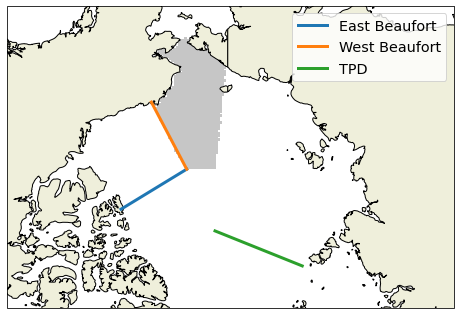

In [5]:
line_width = 50_000

x_grid, y_grid = lonlat_to_xy(lon_grid,lat_grid,hemisphere='n')
xy_grid = np.stack([x_grid,y_grid])
points = [Point(x,y) for x, y in zip(x_grid.ravel(), y_grid.ravel())]

join_point = (203,78.7)

tpd_coords = [(200,86), (90,82)]

gate_coords = [[(242,77), join_point], [(348,81),(11,79.5)], [(205,70.5),join_point], tpd_coords]
gate_names = ['East Beaufort','Fram Strait','West Beaufort', 'TPD']

gate_dict = {}

for coords, name in zip(gate_coords[:], gate_names[:]):
    
    gate_mask, valid_distances_along, line =  get_data_near_line(coords[0],
                                                                 coords[1],
                                                                 line_width,
                                                                 xy_points_grid=points)
    end_points = line.boundary
    
    print(name, line.length)
    
    angle_r = np.arctan2(end_points[1].x - end_points[0].x, end_points[1].y - end_points[0].y)
    angle_d = np.degrees(angle_r)
    

    gate_dict[name] = {'gate_mask':gate_mask,
                       'line':line,
                       'dist_along':valid_distances_along,
                       'end_points':end_points,
                       'angle_r':angle_r,
                       'angle_d':angle_d}
    
pickle.dump(gate_dict, open('../pickles/gd.p','wb'))

#########################################################################

fig = plt.figure(figsize=(8,8))    

ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

ax.set_extent([-180, 180, 90, 66], ccrs.PlateCarree())

handles = []

for gate in ['East Beaufort','West Beaufort', 'TPD']:
    
    point1, point2 = gate_dict[gate]['end_points']
    
#     print(point1)

    handles.append(ax.plot([point1.x, point2.x],[point1.y, point2.y],
#              color='k',
#              ls=':',
             lw=3,
             label=gate))


ax.legend(loc='upper right', fontsize='x-large')

chuk = mask.select_region('Chukchi',np.ones((361,361)))
ax.pcolormesh(lon_grid,lat_grid,chuk[:-1,:-1],transform=ccrs.PlateCarree(),cmap='Greys_r',vmin=0,vmax=1.5)
    
    

ax.set_extent([-2.633e+06,
               2.696e+06,
               -5e5,
               3.1e+06], crs=ccrs.NorthPolarStereo()) 


# Find and plot midpoint of East Beaufort gate

In [6]:
EB_line = gate_dict['East Beaufort']['line']
EB_centre = list(EB_line.centroid.coords)[0]

EB_point1, EB_point2 = gate_dict['East Beaufort']['end_points']

x1q, y1q = (EB_point1.x + EB_centre[0])/2, (EB_point1.y + EB_centre[1])/2

x3q, y3q = (EB_point2.x + EB_centre[0])/2, (EB_point2.y + EB_centre[1])/2

# Get nearest EASE grid point of midpoint

In [7]:
ease_x, ease_y = lonlat_to_xy(lon_grid,lat_grid,hemisphere='n')

ease_xy = np.array(list(zip(ease_x.ravel(),ease_y.ravel())))

tree = KDTree(ease_xy)

def get_nearest_index(x,y):

    dist, ind = tree.query((x,y))

    unraveled = np.unravel_index(ind, (361,361))
    
    return unraveled

unraveled = get_nearest_index(EB_centre[0], EB_centre[1])

lon_nearest, lat_nearest = lon_grid[unraveled], lat_grid[unraveled]

x0, y0 = ease_x[unraveled], ease_y[unraveled]

(x0,y0)

(-877363.2723053514, 927498.3318677363)

In [8]:
def get_gate_comp(dX,dY,gate):

    if gate in ['West Beaufort', 'East Beaufort']:
        gate_comp = dY * np.sin(gate_dict[gate]['angle_r'])  - dX * np.cos(gate_dict[gate]['angle_r'])
    elif gate in ['Fram Strait','TPD']:
        gate_comp = dX * np.cos(gate_dict[gate]['angle_r']) - dY * np.sin(gate_dict[gate]['angle_r'])
    else: 
        print(gate)
        raise
        
    return gate_comp

def calculate_flux(gate_velocities, sit, MYI_dist, gate_data, plot=False, concs=np.nan):
    
    # Make blank arrays

    area_arr = np.full(gate_velocities.shape[0], np.nan)
    MYI_area_arr = np.full(gate_velocities.shape[0], np.nan)
    vol_arr = np.full(gate_velocities.shape[0], np.nan)
    
    MYI_velocities = np.multiply(gate_velocities, MYI_dist)
    
    for i in range(area_arr.shape[0]):
        
        list_of_tups = [(gate_velo,
                         MYI_velo,
                         gate_mask,
                         t)        for (gate_velo,
                                        MYI_velo,
                                         gate_mask,
                                         t)           in zip(gate_velocities[i].ravel(),
                                                             MYI_velocities[i].ravel(),
                                                              gate_data['dist_along'].ravel(),
                                                              sit[i].ravel(),
                                                              ) if (~np.isnan(gate_velo) & ~np.isnan(gate_mask))]
        
        val_vels, MYI_vels, val_dists, val_sits = zip(*list_of_tups)

        af, bin_edges, bn = binned_statistic(val_dists,val_vels,bins=20)
        
        MYI_af, bin_edges, bn = binned_statistic(val_dists,MYI_vels,bins=20)
        
        if plot:
            plt.scatter(val_dists,val_vels,marker='x')        
            plt.plot(bin_edges[1:],af,marker='o')
            print(af)
            plt.show()
            
        area_arr[i] = np.trapz(np.nan_to_num(af),bin_edges[1:])
        
        MYI_area_arr[i] = np.trapz(np.nan_to_num(MYI_af),bin_edges[1:])
        
        if np.count_nonzero(sit):
            vol_fluxes = np.multiply(val_sits, val_vels)
            vf, bin_edges, bn = binned_statistic(val_dists,vol_fluxes,bins=20)
            vol_arr[i] = np.trapz(np.nan_to_num(vf),bin_edges[1:])        

    return (area_arr,vol_arr, MYI_area_arr)

In [9]:
def get_2020_21():
    
    d = Dataset('/media/robbie/TOSHIBA EXT/weekly_NSIDC_IMV/icemotion_weekly_nh_25km_20200101_20210304_ql.nc')
    print(d)
    u = d['u'][48:60]
    v = d['v'][48:60]
    
    return(u,v)

def get_first_eight(winter_year):
    data_dir = '/media/robbie/TOSHIBA EXT/weekly_NSIDC_IMV/'
    fname = f'icemotion_weekly_nh_25km_{winter_year}0101_{winter_year}1231_v4.1.nc'
    d = Dataset(f'{data_dir}{fname}')
    
    u = np.array(d['u'][:8])
    v = np.array(d['v'][:8])
    
    return(u,v)

def get_last_four(winter_year):
    data_dir = '/media/robbie/TOSHIBA EXT/weekly_NSIDC_IMV/'
    fname = f'icemotion_weekly_nh_25km_{winter_year-1}0101_{winter_year-1}1231_v4.1.nc'
    d = Dataset(f'{data_dir}{fname}')
    u = np.array(d['u'][-4:])
    v = np.array(d['v'][-4:])
    return(u,v)

vels = {}

for winter_year in tqdm.trange(1980,2022):

    
    if winter_year < 2021:
        u8,v8 = get_first_eight(winter_year)
        u4,v4 = get_last_four(winter_year)

        u = np.concatenate([u4,u8])
        v = np.concatenate([v4,v8])
        
    elif winter_year == 2021:
        u, v = get_2020_21()
    
    u = np.ma.masked_where(u == -9999, u)
    v = np.ma.masked_where(v == -9999, v)
    u = np.ma.filled(u,np.nan)/100
    v = np.ma.filled(v,np.nan)/100
#     cartoplot(elons,elats,u[0],land=False)
    
    vels[winter_year] = (u,v)

 98%|█████████▊| 41/42 [00:07<00:00,  8.81it/s]/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  after removing the cwd from sys.path.
100%|██████████| 42/42 [00:07<00:00,  5.41it/s]

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    version: QuickLook data based on Ice Motion version 4.1
    release_date: March 2021
    Conventions: CF-1.4
    citation: Tschudi, M. A., Meier, W. N., and Stewart, J. S.: An enhancement to sea ice motion and age products, The Cryosphere Discuss., https://doi.org/10.5194/tc-2019-40, in review, 2019.
    dataset_doi: 10.5067/O0XI8PPYEZJ6
    dimensions(sizes): x(361), y(361), time(61)
    variables(dimensions): float64 x(x), float64 y(y), float64 time(time), int32 crs(), float32 u(time,y,x), float32 v(time,y,x), int16 number_of_observations(time,y,x), float32 latitude(y,x), float32 longitude(y,x)
    groups: 



In [10]:
vels_2021 = np.array(vels[2021])

coords_sets = []

init_coords = [(EB_centre[0], EB_centre[1]),
               (x1q,y1q),
               (x3q,y3q)]

for start_coords in init_coords:
    
    x = start_coords[0]
    y = start_coords[1]

    coords = [(x,y)]

    for wk_num in reversed(np.arange(12)):

        indices = get_nearest_index(x,y)

        vels_wk = vels_2021[:,wk_num,indices[0],indices[1]]

        vels_wk_meters_per_wk = (vels_wk) * 3600 * 24 * 7

        x = x-vels_wk_meters_per_wk[0]
        y = y-vels_wk_meters_per_wk[1]

        coords.append((x,y))

    coords_sets.append(coords)

351493.3951109823
407741.5231288095
308699.88629677455


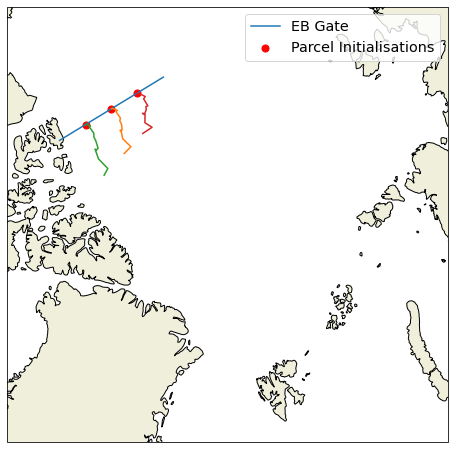

In [12]:
fig = plt.figure(figsize=(8,8))    

ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

ax.set_extent([-180, 180, 90, 75], ccrs.PlateCarree())

ax.scatter(x=EB_centre[0], y=EB_centre[1],marker='o',label='Parcel Initialisations',color='r',s=50)
ax.scatter(x=x1q, y=y1q,marker='o',color='r',s=50)
ax.scatter(x=x3q, y=y3q,marker='o',color='r',s=50)

ax.plot([EB_point1.x, EB_point2.x],[EB_point1.y, EB_point2.y],label='EB Gate')

for coords in coords_sets:

    ax.plot([c[0] for c in coords],[c[1] for c in coords])
    
    dist_traveled = np.array(coords[0]) - np.array(coords[-1])
    
    print(np.sqrt(np.sum(np.square(dist_traveled))))
    
plt.legend(fontsize='x-large')

sup_fig_dir = '/home/robbie/Dropbox/Apps/Overleaf/Beaufort/Sup_figs'
plt.savefig(f'{sup_fig_dir}/backtrack.jpg',dpi=500,bbox_inches='tight')

In [30]:
vel_2021 = np.nanmean(vels_2021, axis=1)
vel_2021.shape

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


(2, 361, 361)

# Ice motion climatology and 2021

In [14]:
speed_21 = np.sqrt(np.square(vel_2021[0]) + np.square(vel_2021[1]))

print(speed_21.shape)

x10n21 = np.divide(vel_2021[0], speed_21)
y10n21 = np.divide(vel_2021[1], speed_21)


clim_vels = []

for key in vels.keys():
    
    if key != 2021:
        clim_vels.append( np.array( vels[key]) )
        
climatology_vel = np.nanmean(np.array(clim_vels),axis=(0,2))

climatology_speed = np.sqrt(np.square(climatology_vel[0]) + np.square(climatology_vel[1]))

climatology_speed[np.isnan(speed_21)] = np.nan

x10nc = np.divide(climatology_vel[0], climatology_speed)
y10nc = np.divide(climatology_vel[1], climatology_speed)


(361, 361)


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


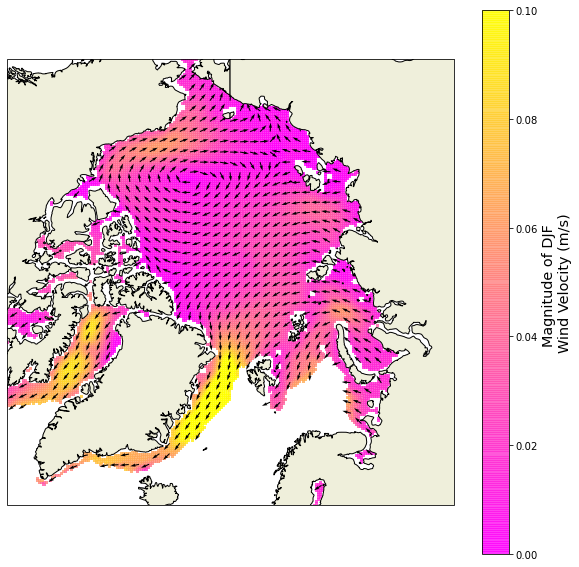

In [15]:
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.margins()

s = 5
scale = 50
size_lim = 1000

bg = ax.pcolormesh(lon_grid, 
                   lat_grid, 
                   climatology_speed[:-1,:-1], 
                    vmin = 0, 
                    vmax = 0.1,
                    transform=ccrs.PlateCarree(),
                    cmap='spring',
                    alpha=0.8)

qv =   ax.quiver(lon_grid[::s,::s],
                 lat_grid[::s,::s],
                 x10nc[::s,::s],
                 y10nc[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                )


qv.set_UVC(U=x10nc[::s,::s],
           V=y10nc[::s,::s])

cb = plt.colorbar(bg)

cb.set_label('Magnitude of DJF \nWind Velocity (m/s)',fontsize='x-large')

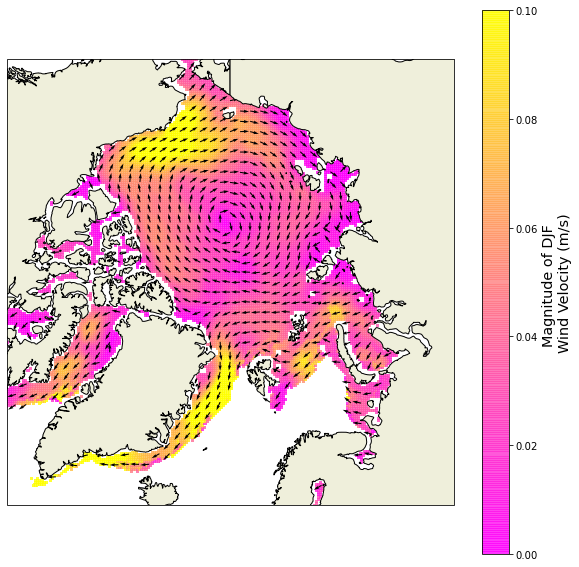

In [16]:
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.margins()

s = 5
scale = 50
size_lim = 1000

bg = ax.pcolormesh(lon_grid, 
                   lat_grid, 
                   speed_21[:-1,:-1], 
                    vmin = 0, 
                    vmax = 0.1,
                    transform=ccrs.PlateCarree(),
                    cmap='spring',
                    alpha=0.8)

qv =   ax.quiver(lon_grid[::s,::s],
                 lat_grid[::s,::s],
                 x10n21[::s,::s],
                 y10n21[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                )


qv.set_UVC(U=x10n21[::s,::s],
           V=y10n21[::s,::s])

cb = plt.colorbar(bg)

cb.set_label('Magnitude of DJF \nWind Velocity (m/s)',fontsize='x-large')

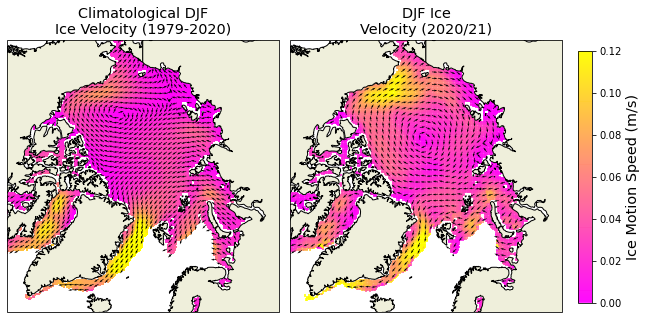

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),subplot_kw={'projection': ccrs.NorthPolarStereo()})

ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax1.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax1.margins()

s = 4
scale = 50
size_lim = 1000

bg = ax1.pcolormesh(lon_grid, 
                   lat_grid, 
                   climatology_speed[:-1,:-1], 
                    vmin = 0, 
                    vmax = 0.1,
                    transform=ccrs.PlateCarree(),
                    cmap='spring',
                    alpha=1)

qv =   ax1.quiver(lon_grid[::s,::s],
                 lat_grid[::s,::s],
                 x10nc[::s,::s],
                 y10nc[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                )

qv.set_UVC(U=x10nc[::s,::s], V=y10nc[::s,::s])


ax1.set_title('Climatological DJF\nIce Velocity (1979-2020)', fontsize='x-large')

####################

ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax2.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax2.margins()

s = 5
scale = 50
size_lim = 1000

bg = ax2.pcolormesh(lon_grid, 
                   lat_grid, 
                   speed_21[:-1,:-1], 
                    vmin = 0, 
                    vmax = 0.12,
                    transform=ccrs.PlateCarree(),
                    cmap='spring',
                    alpha=0.8)

qv =   ax2.quiver(lon_grid[::s,::s],
                 lat_grid[::s,::s],
                 x10n21[::s,::s],
                 y10n21[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                )


qv.set_UVC(U=x10n21[::s,::s], V=y10n21[::s,::s])

ax2.set_title('DJF Ice\nVelocity (2020/21)',fontsize='x-large')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])

cb = fig.colorbar(bg, cax=cbar_ax)

cb.set_label('Ice Motion Speed (m/s)', fontsize='x-large')

plt.subplots_adjust(wspace=0.03)

In [18]:
(norm_djf_x10,norm_djf_y10,djf_ease_wind_speed,
 norm_c_x10, norm_c_y10, c_ease_wind_speed) = pickle.load(open('../pickles/wind_anoms.p','rb'))

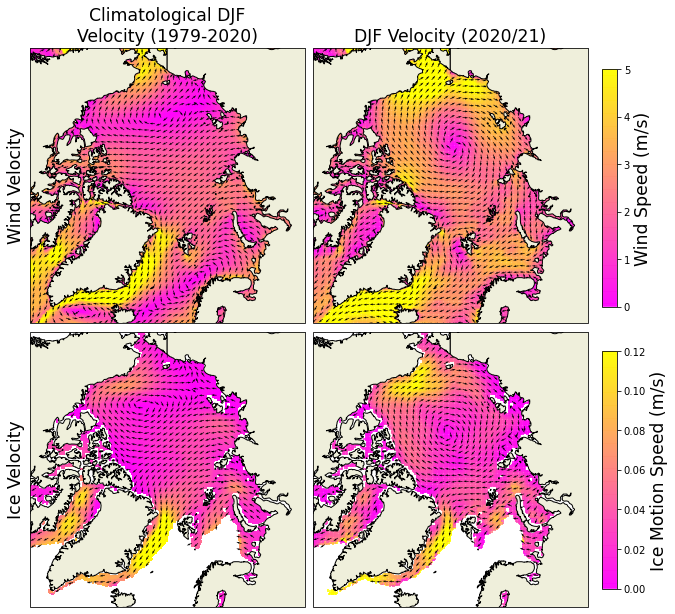

In [19]:
fig, axs = plt.subplots(2,2,figsize=(10,10.3),subplot_kw={'projection': ccrs.NorthPolarStereo()})

(ax1,ax2,ax3,ax4) = axs.reshape(-1)


ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax1.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax1.margins()


s = 5
scale = 50
size_lim = 1000

wind_speed = ax1.pcolormesh(lon_grid, 
                   lat_grid, 
                   c_ease_wind_speed[:-1,:-1], 
                    vmin = 0, 
                    vmax = 5,
                    transform=ccrs.PlateCarree(),
                    cmap='spring',
                    alpha=1)

qv =   ax1.quiver(lon_grid[::s,::s],
                 lat_grid[::s,::s],
                 norm_c_x10[::s,::s],
                 norm_c_y10[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                )

qv.set_UVC(U=norm_c_x10[::s,::s], V=norm_c_y10[::s,::s])


ax1.set_title('Climatological DJF\nVelocity (1979-2020)', fontsize='xx-large')

####################

ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax2.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax2.margins()

wind_speed = ax2.pcolormesh(lon_grid, 
                   lat_grid, 
                   djf_ease_wind_speed[:-1,:-1], 
                    vmin = 0, 
                    vmax = 5,
                    transform=ccrs.PlateCarree(),
                    cmap='spring',
                    alpha=0.8)

qv =   ax2.quiver(lon_grid[::s,::s],
                 lat_grid[::s,::s],
                 norm_djf_x10[::s,::s],
                 norm_djf_y10[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                )


qv.set_UVC(U=norm_djf_x10[::s,::s], V=norm_djf_y10[::s,::s])

ax2.set_title('DJF Velocity (2020/21)',fontsize='xx-large')

#################################################################

ax3.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax3.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax3.margins()


ice_speed = ax3.pcolormesh(lon_grid, 
                   lat_grid, 
                   climatology_speed[:-1,:-1], 
                    vmin = 0, 
                    vmax = 0.1,
                    transform=ccrs.PlateCarree(),
                    cmap='spring',
                    alpha=1)

qv =   ax3.quiver(lon_grid[::s,::s],
                 lat_grid[::s,::s],
                 x10nc[::s,::s],
                 y10nc[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                )

qv.set_UVC(U=x10nc[::s,::s], V=y10nc[::s,::s])


# ax3.set_title('Climatological DJF\nIce Velocity (1979-2020)', fontsize='x-large')

####################

ax4.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax4.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax4.margins()


ice_speed = ax4.pcolormesh(lon_grid, 
                   lat_grid, 
                   speed_21[:-1,:-1], 
                    vmin = 0, 
                    vmax = 0.12,
                    transform=ccrs.PlateCarree(),
                    cmap='spring',
                    alpha=0.8)

qv =   ax4.quiver(lon_grid[::s,::s],
                 lat_grid[::s,::s],
                 x10n21[::s,::s],
                 y10n21[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                )


qv.set_UVC(U=x10n21[::s,::s], V=y10n21[::s,::s])

# ax4.set_title('DJF Ice\nVelocity (2020/21)',fontsize='x-large')

############################################

cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.32])

cb = fig.colorbar(wind_speed, cax=cbar_ax)

cb.set_label('Wind Speed (m/s)', fontsize='xx-large')

#################


cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.32])

cb = fig.colorbar(ice_speed, cax=cbar_ax)

cb.set_label('Ice Motion Speed (m/s)', fontsize='xx-large')

ax1.annotate(xy=(-0.05,0.5),ha='center',va='center',rotation=90,text='Wind Velocity',
             fontsize='xx-large',xycoords='axes fraction')
ax3.annotate(xy=(-0.05,0.5),ha='center',va='center',rotation=90,text='Ice Velocity',
             fontsize='xx-large',xycoords='axes fraction')

plt.subplots_adjust(wspace=0.03,hspace=0.03)

sup_fig_dir = '/home/robbie/Dropbox/Apps/Overleaf/Beaufort/Sup_figs'
plt.savefig(f'{sup_fig_dir}/clim_anoms.jpg',dpi=500,bbox_inches='tight')

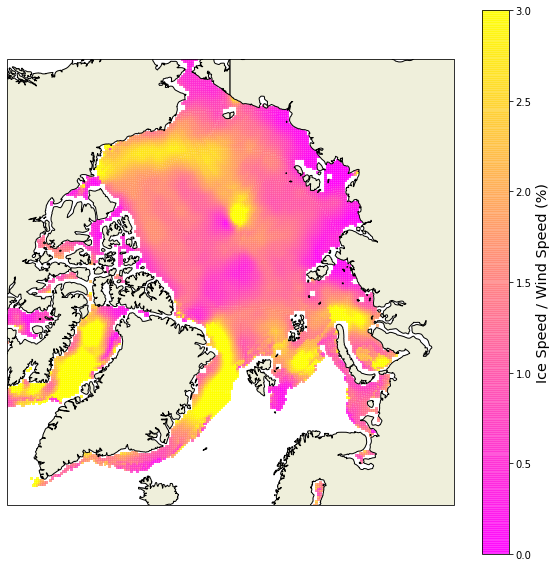

In [20]:
frac = np.divide(speed_21,djf_ease_wind_speed)*100

fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.margins()

bg = ax.pcolormesh(lon_grid, 
                   lat_grid, 
                   frac[:-1,:-1], 
                    vmin = 0, 
                    vmax = 3,
                    transform=ccrs.PlateCarree(),
                    cmap='spring',
                    alpha=0.8)

cb = plt.colorbar(bg)

cb.set_label('Ice Speed / Wind Speed (%)',fontsize='x-large')


In [21]:
ice_angle = np.rad2deg(np.arctan2(x10n21,y10n21))

wind_angle = np.rad2deg(np.arctan2(norm_djf_x10,norm_djf_y10))

frac = np.divide(speed_21,djf_ease_wind_speed)*100

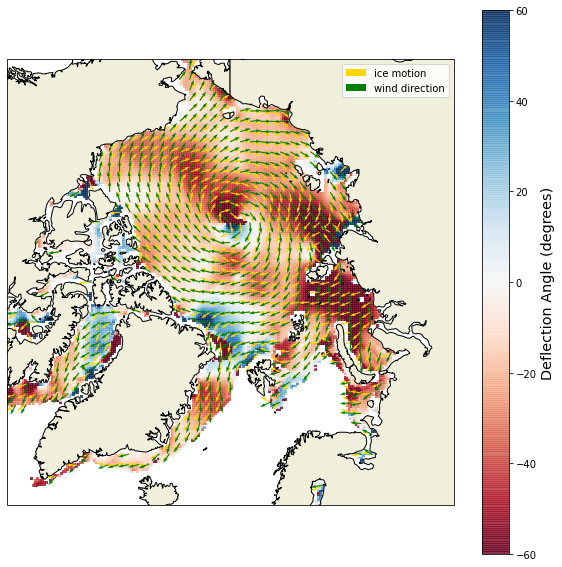

In [22]:
angle_diffs = (wind_angle-ice_angle)

i = np.where(angle_diffs >180)
angle_diffs[i] = -1*(360-angle_diffs[i])

scale = 40

fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.margins()

bg = ax.pcolormesh(lon_grid, 
                   lat_grid, 
                   angle_diffs[:-1,:-1], 
                    vmin = -60, 
                    vmax = 60,
                    transform=ccrs.PlateCarree(),
                    cmap='RdBu',
                    alpha=0.8)

ice =   ax.quiver(lon_grid[::s,::s],
                 lat_grid[::s,::s],
                 x10n21[::s,::s],
                 y10n21[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                 color='gold',
                 label='ice motion',
                )

ice.set_UVC(U=x10n21[::s,::s], V=y10n21[::s,::s])

norm_djf_x10[np.isnan(x10n21)] = np.nan

wind =   ax.quiver(lon_grid[::s,::s],
                 lat_grid[::s,::s],
                 norm_djf_x10[::s,::s],
                 norm_djf_y10[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                 color='g',
                 label='wind direction',
                )


wind.set_UVC(U=norm_djf_x10[::s,::s], V=norm_djf_y10[::s,::s])

cb = plt.colorbar(bg)

cb.set_label('Deflection Angle (degrees)',fontsize='x-large')

plt.legend(loc='upper right')

In [34]:
vel_2021[0][~np.isnan(vel_2021[0])]

array([-0.051 , -0.097 , -0.0445, ..., -0.0055, -0.0155,  0.0035],
      dtype=float32)

In [ ]:
wind

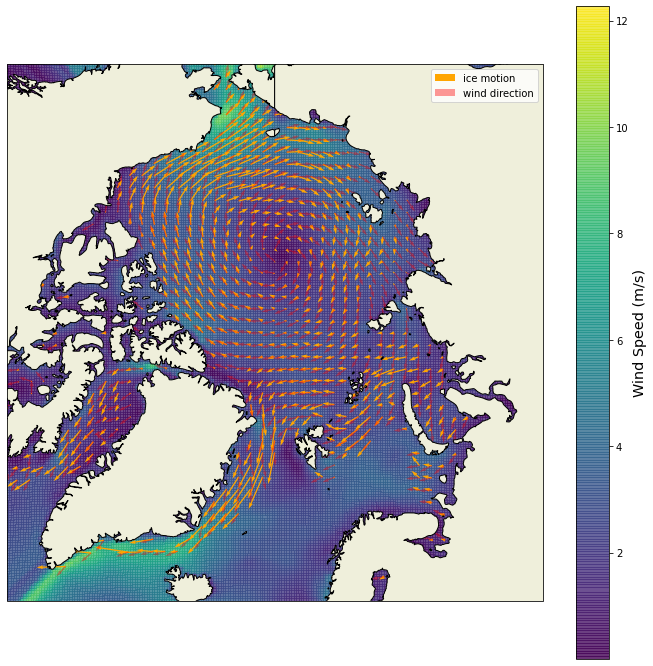

In [52]:
angle_diffs = (wind_angle-ice_angle)

i = np.where(angle_diffs >180)
angle_diffs[i] = -1*(360-angle_diffs[i])

scale = 40

fig = plt.figure(figsize=(12,12))

ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax.margins()

bg = ax.pcolormesh(lon_grid, 
                   lat_grid, 
                   djf_ease_wind_speed[:-1,:-1], 
#                     vmin = -60, 
#                     vmax = 60,
                    transform=ccrs.PlateCarree(),
#                     cmap='plasma',
                    alpha=0.8)

ice =   ax.quiver(lon_grid[::s,::s],
                 lat_grid[::s,::s],
                 vel_2021[0][::s,::s],
                 vel_2021[1][::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=2,
                 color='orange',
                 label='ice motion',
                )

ice.set_UVC(U=vel_2021[0][::s,::s], V=vel_2021[1][::s,::s])

norm_djf_x10[np.isnan(x10n21)] = np.nan

wind =   ax.quiver(lon_grid[::s,::s],
                 lat_grid[::s,::s],
                 norm_djf_x10[::s,::s],
                 norm_djf_y10[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                 color='r',
                 label='wind direction',
                 alpha=0.4,
                )


wind.set_UVC(U=norm_djf_x10[::s,::s], V=norm_djf_y10[::s,::s])

cb = plt.colorbar(bg)

cb.set_label('Wind Speed (m/s)',fontsize='x-large')

plt.legend(loc='upper right')

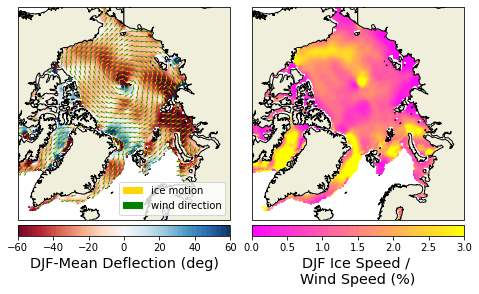

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2,
                              subplot_kw={'projection': ccrs.NorthPolarStereo()},
                              figsize=(8,5))


ax1.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax1.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax1.margins()

d = ax1.pcolormesh(lon_grid, 
                   lat_grid, 
                   angle_diffs[:-1,:-1], 
                    vmin = -60, 
                    vmax = 60,
                    transform=ccrs.PlateCarree(),
                    cmap='RdBu',
                    alpha=0.8)

ice =   ax1.quiver(lon_grid[::s,::s],
                 lat_grid[::s,::s],
                 x10n21[::s,::s],
                 y10n21[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                 color='gold',
                 label='ice motion',
                )

ice.set_UVC(U=x10n21[::s,::s], V=y10n21[::s,::s])

norm_djf_x10[np.isnan(x10n21)] = np.nan

wind =   ax1.quiver(lon_grid[::s,::s],
                 lat_grid[::s,::s],
                 norm_djf_x10[::s,::s],
                 norm_djf_y10[::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                 color='g',
                 label='wind direction',
                )


wind.set_UVC(U=norm_djf_x10[::s,::s], V=norm_djf_y10[::s,::s])

# cb = ax1.colorbar(bg)

# cb.set_label('Deflection Angle (degrees)',fontsize='x-large')

ax1.legend(loc='lower right')

###########################################

ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    

ax2.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)
ax2.margins()

bg = ax2.pcolormesh(lon_grid, 
                   lat_grid, 
                   frac[:-1,:-1], 
                    vmin = 0, 
                    vmax = 3,
                    transform=ccrs.PlateCarree(),
                    cmap='spring',
                    alpha=0.8)

##############

cb_r = fig.colorbar(bg, ax=ax2, orientation='horizontal',pad=0.02,shrink=1)

cb_r.set_label('DJF Ice Speed / \nWind Speed (%)',fontsize='x-large')

##############


cb_l = fig.colorbar(d, ax=ax1, orientation='horizontal',pad=0.02,shrink=1)

cb_l.set_label('DJF-Mean Deflection (deg)',fontsize='x-large')

##############

plt.subplots_adjust(wspace=0.1)


sup_fig_dir = '/home/robbie/Dropbox/Apps/Overleaf/Beaufort/Sup_figs'
plt.savefig(f'{sup_fig_dir}/wind_ice_response.jpg',dpi=500,bbox_inches='tight')